<a href="https://colab.research.google.com/github/girish-srivatsa/itsp/blob/master/google%20colab/Emotify_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing necessary libraries
import numpy as np
import tensorflow as tf
import keras 
from keras import layers         
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv1D, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout 
from keras.models import Model       
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from google.colab.patches import cv2_imshow        
import cv2
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Using TensorFlow backend.


In [ ]:
url = "https://drive.google.com/open?id=1QRkgQ0dzP_Occx2j-STNl8D2qz-24gM5"  #source of data
url_id = "1QRkgQ0dzP_Occx2j-STNl8D2qz-24gM5"

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()                                        
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id' : url_id})      #saving data in csv file
downloaded.GetContentFile('Emotions.csv')

In [ ]:
data = pd.read_csv('Emotions.csv')                 #reading the csv file and storing in a data frame
data.head()

,emotion,pixels,Usage
0,0,86 104 151 119 35 26 36 36 35 33 31 33 32 34 3...,Training
1,4,30 30 28 30 27 23 11 5 6 9 13 20 34 52 75 106 ...,Training
2,3,226 226 225 223 223 216 210 214 208 198 192 18...,Training
3,4,180 133 85 75 63 63 66 67 66 58 51 66 84 102 1...,Training
4,0,14 15 32 72 82 113 180 147 45 49 54 74 67 79 7...,Training


In [ ]:
for i in range(data.shape[0]):
  pix_list = [float(x) for x in data['pixels'][i].split(' ')]
  # pix_list = norm_list(pix_list)
  pix_arr = np.array(pix_list)
  pix_img = np.reshape(pix_arr, (48, 48))           #pre processing
  pix_img_to_list = pix_img.tolist()
  data['pixels'][i] = pix_img_to_list

data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,emotion,pixels,Usage
0,0,"[[86.0, 104.0, 151.0, 119.0, 35.0, 26.0, 36.0,...",Training
1,4,"[[30.0, 30.0, 28.0, 30.0, 27.0, 23.0, 11.0, 5....",Training
2,3,"[[226.0, 226.0, 225.0, 223.0, 223.0, 216.0, 21...",Training
3,4,"[[180.0, 133.0, 85.0, 75.0, 63.0, 63.0, 66.0, ...",Training
4,0,"[[14.0, 15.0, 32.0, 72.0, 82.0, 113.0, 180.0, ...",Training


In [ ]:
data['pixels'][0][0][0]

86.0

In [ ]:
dftrain = data[data['Usage'] == 'Training']
dfdev = data[data['Usage'] == 'PublicTest']
dftest = data[data['Usage'] == 'PrivateTest']
print(dftrain.shape, dfdev.shape, dftest.shape) #splitting the data                                                    
dftrain.head()

(30694, 3) (4089, 3) (4122, 3)


,emotion,pixels,Usage
0,0,"[[86.0, 104.0, 151.0, 119.0, 35.0, 26.0, 36.0,...",Training
1,4,"[[30.0, 30.0, 28.0, 30.0, 27.0, 23.0, 11.0, 5....",Training
2,3,"[[226.0, 226.0, 225.0, 223.0, 223.0, 216.0, 21...",Training
3,4,"[[180.0, 133.0, 85.0, 75.0, 63.0, 63.0, 66.0, ...",Training
4,0,"[[14.0, 15.0, 32.0, 72.0, 82.0, 113.0, 180.0, ...",Training


AxesSubplot(0.125,0.125;0.775x0.755)


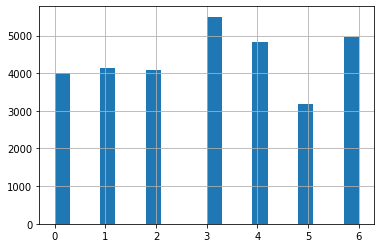

In [ ]:
print(dftrain.emotion.hist(bins = 20))
# print(dfdev.emotion.hist(bins = 20))
# print(dftest.emotion.hist(bins = 20))

In [ ]:
train_count = dftrain.shape[0]
dev_count = dfdev.shape[0]
test_count = dftest.shape[0]
img_h = 48
img_w = 48

In [ ]:
y_train = np.array(dftrain['emotion'])
y_dev = np.array(dfdev['emotion'])
y_test = np.array(dftest['emotion'])
                          
Y_train = tf.keras.utils.to_categorical(y_train, num_classes = 7)         #one hot encoding
Y_dev = tf.keras.utils.to_categorical(y_dev, num_classes = 7)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes = 7)

# print(Y_train)

In [ ]:
def get_X(df, start, end):
  x_list = []
  for i in range(start, end):
    x_list.append(df['pixels'][i])                        #making values btwn 0 and 1
  X = np.array(x_list)
  X = X / 255.0
  return X

In [ ]:
X_train = get_X(dftrain, 0, train_count)
X_dev = get_X(dfdev, train_count, train_count + dev_count)
X_test = get_X(dftest, train_count + dev_count, train_count + dev_count + test_count)

X_train.shape = (30694, 48, 48, 1)
X_dev.shape = (4089, 48, 48, 1)
X_test.shape = (4122, 48, 48, 1)

In [ ]:
from keras.regularizers import l2
from keras.layers import SeparableConv2D                           #importing libraries
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#model structure
def train_Model(input_shape,num_classes,l2_regularization=0.01):
    regularization = l2(l2_regularization)
 
    # base
    img_input = Input(input_shape)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
 
    # module 1                           
    residual = Conv2D(8, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
 
    x = SeparableConv2D(8, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(8, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
 
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
 
    # module 2
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
 
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
 
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
 
    # module 3
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
 
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
 
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
 
    # module 4
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
 
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
 
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
    
    """x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)"""
    x=Flatten()(x)
    #x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)
 
    model = Model(img_input, output)
    return model

In [ ]:
Emotion_Model = train_Model((48, 48, 1),7)

In [ ]:
Emotion_Model.summary() #model summary

In [ ]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
patience=50

In [ ]:
#using image data generator and callback
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(patience/4), verbose=1)

#model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1, save_best_only=True)
callbacks = [early_stop, reduce_lr]  


In [ ]:
Emotion_Model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])

In [ ]:
Emotion_Model.summary()

In [ ]:
Emotion_Model.fit_generator(data_generator.flow(X_train, Y_train,
                                            32),
                        steps_per_epoch=len(X_train) / 32,
                        epochs=1000, verbose=1, callbacks=callbacks,
                        validation_data=(X_dev,Y_dev))

In [ ]:
#evaluating on test set
Emotion_Model.evaluate(X_test, Y_test, batch_size = 32, verbose = 1) 

4122/4122 [==============================] - 1s 170us/step


[0.902482979827457, 0.6695778965950012]

In [ ]:
import dlib
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

#extracting the faces
def detect_faces(image):

    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Run detector and get bounding boxes of the faces on image.
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]  

    return face_frames

In [ ]:
path='/content/output.jpg'

In [ ]:
imager=cv2.imread(path)

In [ ]:
datagen=ImageDataGenerator(
    featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [ ]:
l=datagen.flow(
    tf.keras.backend.expand_dims(imager,axis=0), y=None, batch_size=32, shuffle=True, sample_weight=None, seed=None,    
)

In [ ]:
#using image data generator to improve prediction image but time taking
b=np.array([0.,0.0,0.0,0.0,0.0,0.0,0.0])
limiter=0
limit_max=20
b1=[0,0,0,0,0,0,0]

In [ ]:
s=np.zeros((imager.shape))

In [ ]:
# Detect faces
a=time.time()
for p1 in l:
  if(limiter>limit_max):
    break
  #print(imager.shape)
  detected_faces = detect_faces(np.squeeze(p1).astype(np.uint8))
  #print(detected_faces)
# Crop faces and plot
  for n, face_rect in enumerate(detected_faces):
    face = Image.fromarray(np.squeeze(p1).astype(np.uint8)).crop(face_rect)
    face.thumbnail((48, 48), Image.ANTIALIAS)
    face = face.convert('L')
    #face.save(path)
  face_arr = np.asarray(face, dtype = np.float32)
  face_arr = face_arr / 255
#print(face_arr.shape)
# face_arr
  face_arr.shape = (1, 48, 48, 1)
  #plt.imshow(face_arr.reshape(48,48), interpolation="none")
  #plt.show()
  x2=model1.predict(face_arr)
  b+=x2[0]
  limiter+=1
c=time.time()
print(c-a)

11.184325218200684


In [ ]:
print(b/limit_max)

[0.25548698 0.00209743 0.03671282 0.43526475 0.14269257 0.04053099
 0.13721435]


In [ ]:
#predicting without image generator on test face
detected_faces = detect_faces(imager)
  #print(detected_faces)
# Crop faces and plot
for n, face_rect in enumerate(detected_faces):
  face = Image.fromarray(np.squeeze(imager).astype(np.uint8)).crop(face_rect)
  face.thumbnail((48, 48), Image.ANTIALIAS)
  face = face.convert('L')
    #face.save(path)
face_arr = np.asarray(face, dtype = np.float32)
face_arr = face_arr / 255
#print(face_arr.shape)
# face_arr
face_arr.shape = (1, 48, 48, 1)
  #plt.imshow(face_arr.reshape(48,48), interpolation="none")
  #plt.show()
x2=model1.predict(face_arr)
print(x2[0])

[0.28661758 0.00333528 0.04774178 0.33545223 0.16974306 0.03656797
 0.12054209]


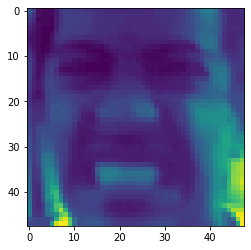

In [ ]:
face_arr = np.asarray(face, dtype = np.float32)
face_arr = face_arr / 255
#print(face_arr.shape)
# face_arr
face_arr.shape = (1, 48, 48, 1)
plt.imshow(face_arr.reshape(48,48), interpolation="none")
plt.show()

In [ ]:
#x=model2.predict(face_arr)
x1=model1.predict(face_arr)

In [ ]:
print(x2[0])

[0.2866174  0.00333528 0.04774167 0.33545244 0.16974296 0.03656795
 0.12054233]


In [ ]:
print(x1[0])

[0.1551418  0.00045477 0.13383994 0.13168201 0.10984278 0.30673426
 0.16230443]


In [ ]:
print(X_test.shape)

(4122, 48, 48, 1)


In [ ]:
l=[] #predicted emotion
m=[]  #actual emotiom
n=[]   #indices of image
for i in range(4122):
  
  temper=model1.predict(X_test[i].reshape(1,48,48,1))
  p=np.argmax(temper[0])                         #storing the misclassified images
  p1=np.argmax(Y_test[i])
  if p!=p1:
    l.append(p)
    m.append(p1)
    n.append(i)

In [ ]:
def fun(actual,predicted):
  for i in range(len(l)):
    if(l[i]==actual and m[i]==predicted):
      temper=model1.predict(X_test[i].reshape(1,48,48,1))
      yield temper,i


In [ ]:
vec,index=next(fun(6,4))

In [ ]:
print(vec),print(Y_test[i])

[[0.48764303 0.00356721 0.19613154 0.2213646  0.0491555  0.02162113
  0.02051707]]
[0. 0. 0. 1. 0. 0. 0.]


(None, None)

In [ ]:
print(len(l))

1362


In [ ]:
p=[]
for i in range(7):
  p.append([0,0,0,0,0,0,0])
for i in range(len(l)):
  p[l[i]][m[i]]+=1


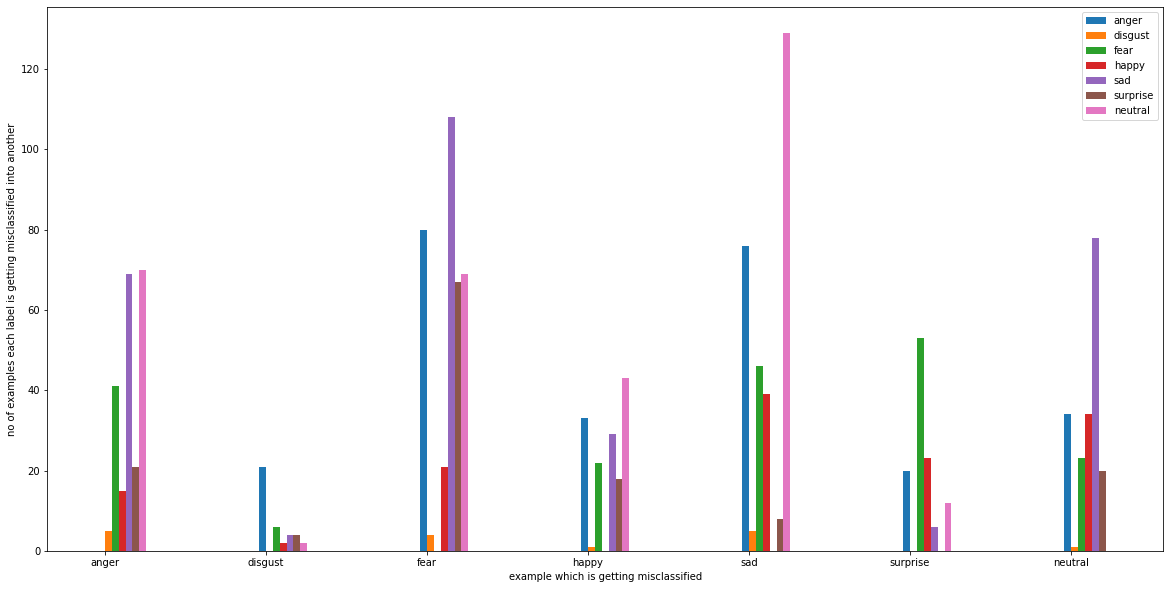

In [ ]:
plt.figure(figsize=(20, 10))
x=7*np.arange(7)
bar_width=0.3                 #plotting the misclassified images to correct one
for i in range(7):
  plt.bar(x+bar_width*i,p[i],width=bar_width)
plt.xticks(x + 0.5*bar_width, ['anger','disgust', 'fear', 'happy','sad','surprise','neutral'])
plt.legend(['anger','disgust', 'fear', 'happy','sad','surprise','neutral'])
plt.xlabel("example which is getting misclassified")
plt.ylabel("no of examples each label is getting misclassified into another")
plt.show()

In [ ]:
import csv

In [ ]:
with open("values.csv",'w') as csvfile:  #storing the indices for future use
  csv_writer=csv.writer(csvfile)
  csv_writer.writerow(l)
  csv_writer.writerow(m)
  csv_writer.writerow(n)


In [ ]:
% cd drive/My Drive

/content/drive/My Drive


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [ ]:
Emotion_Model.save('Model_folder/model_1') #saving model in google drive

In [ ]:
import tensorflow as tf

In [ ]:
model1=tf.keras.models.load_model('Model_folder/model_1')  #loading model from google drive

In [ ]:
model2=tf.keras.models.load_model('h5typemodel1.h5')

In [ ]:
model1.save('h5typemodel1.h5')